# Creazione modello per previsione SQUAT

> Logistic Regression 

In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss, precision_score, recall_score
from sklearn import tree
from matplotlib import pyplot as plt
import seaborn as sns
import os

In [58]:
shift = 1
rolling_periods = 3

## Import dati

In [59]:
# Scelta automatica del Path locale tra "paoloartasensi" o "lorenzobassetti"
path = '/Users/paoloartasensi/Python_Scripts/'
isdir = os.path.isdir(path)
if isdir == True:
    path = '/Users/paoloartasensi/Python_Scripts/'
else:
    path = '/Users/lorenzobassetti/Dropbox/Quant/Python_DEV/'

In [60]:
df2 = pd.read_csv(path+'artabax/data_modelli/sq_bax_1207_1.csv' , sep=';' , decimal='.')
df3 = pd.read_csv(path+'artabax/data_modelli/sq_bax_1207_2.csv' , sep=';' , decimal='.')
df4 = pd.read_csv(path+'artabax/data_modelli/sq_paolo_1207_1.csv' , sep=';' , decimal='.')
df5 = pd.read_csv(path+'artabax/data_modelli/sq_paolo_1207_2.csv' , sep=';' , decimal='.')
df_raw = pd.concat([
                    df2,
                    df3,
                    df4,
                    df5,
                    ], axis=0, ignore_index=True).drop(columns=[
                        'prob',
                        'Time',
                        ])
df_raw.reset_index(drop=True, inplace=True)

bar_zero = df_raw['BAR'][0]
df_raw['BAR'] = (df_raw['BAR']/bar_zero)
# df_raw.set_index('Time', inplace=True)
df_raw

,Ax,Ay,Az,Gx,Gy,Gz,BAR,P,R,UP,DOWN
0,10.14291,-0.78796,4.04758,6.16000,2.17000,-5.18000,1.000000,0,0,0,0
1,8.75859,-1.01070,3.54223,26.66999,3.08000,-2.87000,1.000003,0,0,0,0
2,9.34297,-0.91250,2.89558,29.39999,0.84000,13.30000,0.999990,0,0,0,0
3,10.34649,0.14610,2.75906,38.98999,13.92999,20.78999,0.999996,0,0,0,0
4,10.66263,1.52563,3.32429,21.62999,-1.19000,1.47000,0.999979,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2366,9.88904,-0.56522,1.92320,-0.77000,5.81000,0.28000,1.000015,0,0,1,0
2367,10.12375,-0.55325,2.37586,-2.10000,-2.59000,-0.70000,0.999996,0,0,1,0
2368,10.33451,-0.70414,2.45490,0.56000,1.12000,-2.59000,1.000002,0,0,1,0
2369,10.51653,-0.36883,1.54958,1.47000,3.57000,-12.11000,1.000022,0,0,1,0


In [61]:
df = df_raw.copy()
df.dropna(inplace=True)
df

,Ax,Ay,Az,Gx,Gy,Gz,BAR,P,R,UP,DOWN
0,10.14291,-0.78796,4.04758,6.16000,2.17000,-5.18000,1.000000,0,0,0,0
1,8.75859,-1.01070,3.54223,26.66999,3.08000,-2.87000,1.000003,0,0,0,0
2,9.34297,-0.91250,2.89558,29.39999,0.84000,13.30000,0.999990,0,0,0,0
3,10.34649,0.14610,2.75906,38.98999,13.92999,20.78999,0.999996,0,0,0,0
4,10.66263,1.52563,3.32429,21.62999,-1.19000,1.47000,0.999979,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2366,9.88904,-0.56522,1.92320,-0.77000,5.81000,0.28000,1.000015,0,0,1,0
2367,10.12375,-0.55325,2.37586,-2.10000,-2.59000,-0.70000,0.999996,0,0,1,0
2368,10.33451,-0.70414,2.45490,0.56000,1.12000,-2.59000,1.000002,0,0,1,0
2369,10.51653,-0.36883,1.54958,1.47000,3.57000,-12.11000,1.000022,0,0,1,0


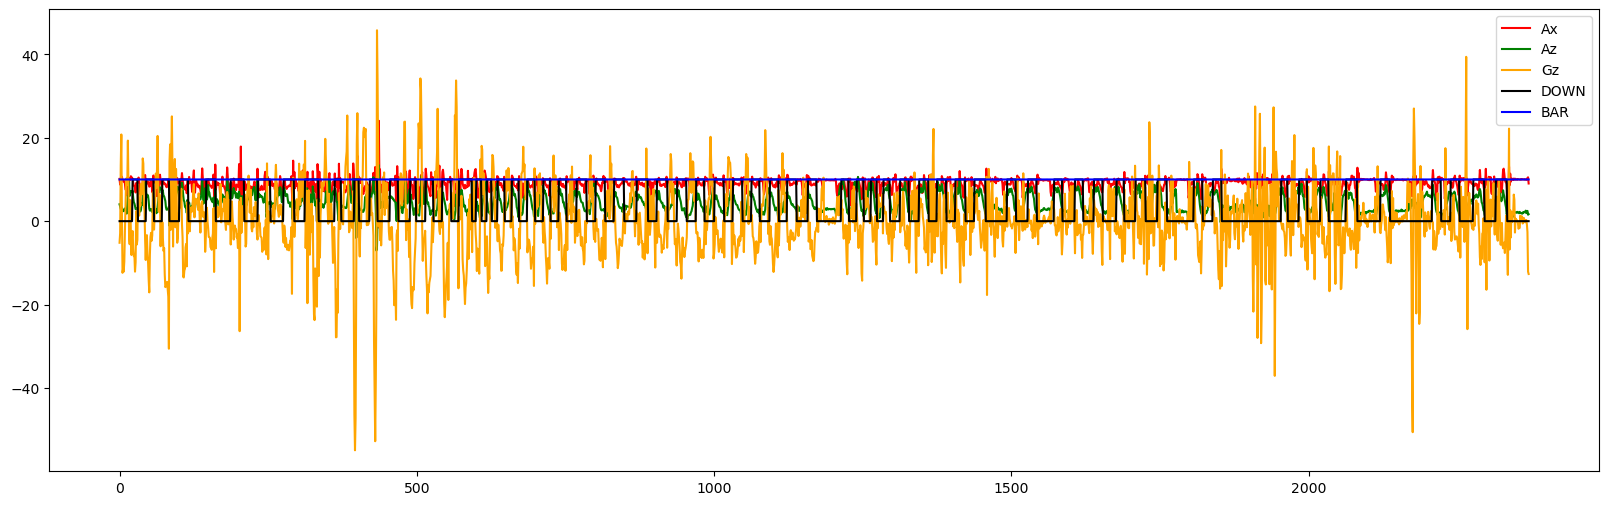

In [62]:
plt.figure(figsize=(20,6))
plt.plot(df['Ax'], color='red', label='Ax')
# plt.plot(df['Ay'], color='blue', label='Ay')
plt.plot(df['Az'], color='green', label='Az')
plt.plot(df['Gz'], color='orange', label='Gz')
plt.plot(df['DOWN']*10, color='black', label='DOWN')
plt.plot(df['BAR']*10, color='blue', label='BAR')
plt.legend()
plt.show()

## Preparazione datasets

In [63]:
## Y è l'output che utilizziamo come training
## X sono le feautures, BISOGNA togliere la Y dalle colonne feautures 
y = df['DOWN']
X = df.copy()
X.drop(columns=['DOWN','UP'], axis=1, inplace=True)

##Divido il campione in Train e Test
X_train, X_test , y_train , y_test = train_test_split(X, y, test_size=0.2, random_state=None)

## Logistic Regression

In [64]:
log_reg = LogisticRegression(random_state=None, solver = 'lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)

# predict - Predict class labels for samples in X
y_pred = log_reg.predict(X_train)

# coef_ - Coefficient of the features in the decision function
log_reg.coef_

lr = pd.DataFrame(data =[X_train.columns, np.array(log_reg.coef_[0]).tolist()]).T
lr.rename(columns={0:'Reg',1:'Logistic'}, inplace=True)
lr.set_index('Reg', inplace=True)
lr.sort_values(by='Logistic', key=abs, ascending=False , inplace=True)
print(lr)
print('b0:',log_reg.intercept_[0])

     Logistic
Reg          
Az   0.479169
Ax  -0.323209
Ay   0.255372
Gy  -0.089141
Gx   0.051882
Gz  -0.022227
BAR  0.003779
P         0.0
R         0.0
b0: 0.353102033091942


LogReg Training Accuracy is:  0.8222573839662447
LogReg Testing Accuracy is:  0.8336842105263158


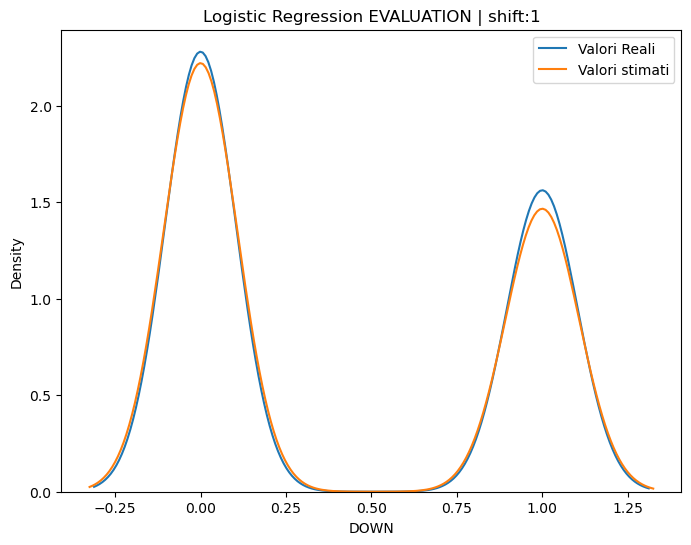

In [65]:
'''Logistic Regression EVALUATION'''

# Accuracy on Train
print("LogReg Training Accuracy is: ", log_reg.score(X_train, y_train))
# Accuracy on Test
print("LogReg Testing Accuracy is: ", log_reg.score(X_test, y_test))
# Classification Report

plt.figure(figsize=(8, 6))
plt.title('Logistic Regression EVALUATION' +' | shift:'+str(shift))
sns.kdeplot(data=df, x='DOWN' , label='Valori Reali')
sns.kdeplot(y_pred , label='Valori stimati')
plt.legend()
plt.show()


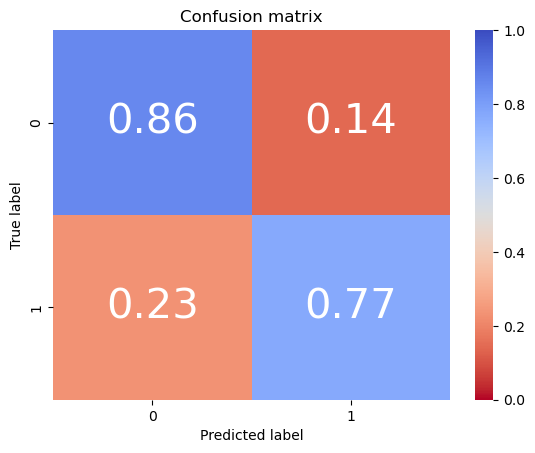

In [66]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="coolwarm_r", 
                    xticklabels=classes, 
                    yticklabels=classes, 
                    vmin=0., vmax=1., 
                    annot=True, annot_kws={'size':30}
                    )
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Visualizing cm

cm = confusion_matrix(y_train, y_pred)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm_norm, classes = log_reg.classes_, title='Confusion matrix')

In [67]:
# Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
print("The True Positive Rate is:", TPR)

# Precision or positive predictive value
PPV = TP / (TP + FP)
print("The Precision is:", PPV)

# False positive rate or False alarm rate
FPR = FP / (FP + TN)
print("The False positive rate is:", FPR)


# False negative rate or Miss Rate
FNR = FN / (FN + TP)
print("The False Negative Rate is: ", FNR)

The True Positive Rate is: [0.85905442 0.76903226]
The Precision is: [0.84325744 0.79045093]
The False positive rate is: [0.23096774 0.14094558]
The False Negative Rate is:  [0.14094558 0.23096774]


In [68]:
# Running Log loss on training
pred_proba_train = log_reg.predict_proba(X_train)
print("The Log Loss on Training is: ", log_loss(y_train, pred_proba_train))

# Running Log loss on testing
pred_proba_test = log_reg.predict_proba(X_test)
print("The Log Loss on Test is: ", log_loss(y_test, pred_proba_test))

The Log Loss on Training is:  0.4019046125023725
The Log Loss on Test is:  0.4167537066546687


In [69]:
# Looping over the parameters
hyper_size = 20

C_List = np.geomspace(1e-5, 1e5, num=hyper_size)
CA = [] #classification accuracy
Logarithmic_Loss = [] #log ross

for c in C_List:
    log_reg2 = LogisticRegression(random_state=10, solver = 'lbfgs', C=c)
    log_reg2.fit(X_train, y_train)
    score = log_reg2.score(X_test, y_test)
    CA.append(score)
    # print("The CA of C parameter {} is {}:".format(c, score))
    pred_proba_test = log_reg2.predict_proba(X_test)
    log_loss2 = log_loss(y_test, pred_proba_test)
    Logarithmic_Loss.append(log_loss2)
    # print("The Logg Loss of C parameter {} is {}:".format(c, log_loss2))
    # print("")
    
#putting the outcomes in a Table

# reshaping
CA2 = np.array(CA).reshape(hyper_size,)
Logarithmic_Loss2 = np.array(Logarithmic_Loss).reshape(hyper_size,)

# zip
outcomes = zip(C_List, CA2, Logarithmic_Loss2)

#df
df_outcomes = pd.DataFrame(outcomes, columns = ["C_List", 'CA2','Logarithmic_Loss2'])

#print
df_outcomes

# Ordering the data (sort_values)
df_outcomes.sort_values("Logarithmic_Loss2", ascending = True).reset_index()

,index,C_List,CA2,Logarithmic_Loss2
0,14,233.572147,0.833684,0.416711
1,13,69.519280,0.833684,0.416711
2,15,784.759970,0.833684,0.416712
3,16,2636.650899,0.833684,0.416712
4,19,100000.000000,0.833684,0.416712
5,18,29763.514416,0.833684,0.416712
6,17,8858.667904,0.833684,0.416712
7,12,20.691381,0.833684,0.416714
8,11,6.158482,0.833684,0.416720
9,10,1.832981,0.833684,0.416742


In [70]:
# Another way of doing the above
# Scikit-learn offers a LogisticRegressionCV module which implements Logistic Regression 
# with builtin cross-validation to find out the optimal C parameter
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, random_state=None, shuffle=True)

Log_reg4 = LogisticRegressionCV(random_state=5, Cs = C_List, solver ='lbfgs', cv=kf)
Log_reg4.fit(X_train, y_train)
print("The CA is:", Log_reg4.score(X_test, y_test))
pred_proba_t = Log_reg4.predict_proba(X_test)
log_loss4 = log_loss(y_test, pred_proba_t)
print("The Logistic Loss is: ", log_loss4)
print("The optimal C parameter is: ", Log_reg4.C_)

The CA is: 0.8126315789473684
The Logistic Loss is:  0.42738892790221955
The optimal C parameter is:  [0.00428133]
